### Tax Data by Income

From Tim:

I just found a better link to the income data I was telling you about:
http://www.cra-arc.gc.ca/gncy/stts/t1fnl-eng.html
 
<p>you can click on one of the three available years and then get the data in PDF or CSV (we had a poor intern clean up a machine converted version of the pdf). "Final Table 2 - All returns by total income class" is the one I think most interesting.
 
<p>there are a bunch of other tax filing related datasets available here: http://www.cra-arc.gc.ca/gncy/stts/menu-eng.html including 'T1 preliminary statistics' which are similar to the first link but run from 2006 to 2012.

I may want to switch to the preliminary files and try to convert those: http://www.cra-arc.gc.ca/gncy/stts/ntrm-eng.html

And here is a description of all the line items: http://www.cra-arc.gc.ca/gncy/stts/gb11/pst/fnl/dsctm-eng.html

In [2]:
import matplotlib

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter

#### Data handling for plotting functions

In [14]:
def number_formatter(n):
    "Find the correct suffix, divide the original number, and return the new number + suffix"
    if 0 <= n < 1E3: 
        suffix = ' '
    elif 1E3 <= n < 1E6:
        suffix = 'k'
    elif 1E6 <= n < 1E9:
        suffix = 'M'
    elif 1E9 <= n < 1E12:
        suffix = 'B'
    elif 1E12 <= n < 1E15:
        suffix = 'T'
    else:
        suffix = 'really big!'
    
    order = {' ':1., 'k':1E3, 'M':1E6, 'B':1E9, 'T':1E12, 'really big!':1.}
    suffix2print = {' ':'', 'k':'k', 'M':'M', 'B':'B', 'T':'T', 'really big!':'really big!'}
    smaller_n = n / order[suffix]
    
    if smaller_n%1 < 0.0001: 
        return str(int(smaller_n)) + suffix2print[suffix]
    else: 
        return str(smaller_n) + suffix2print[suffix]
    
def _mpl_dollar_formatter(y, position): return '$' + number_formatter(y)

def _mpl_number_formatter(y, position): return number_formatter(y)

def _mpl_percent_formatter(y, position): return number_formatter(100 * y) + '%'
    
mpl_number_formatter = FuncFormatter(_mpl_number_formatter)
mpl_dollar_formatter = FuncFormatter(_mpl_dollar_formatter)
mpl_percent_formatter = FuncFormatter(_mpl_percent_formatter)

def bar_plot(values, title, labels=[], xformatter=None):
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.barh(range(len(values)), values, align='center', color='grey', edgecolor='grey');
    ax.set_ylim([-1, len(values)])
    ax.set_yticks(range(len(values)))
    ax.set_yticklabels(labels)
    ax.vlines(ax.get_xticks(), ax.get_ybound()[0], ax.get_ybound()[1], color='white', linewidth=2)
    if xformatter: ax.xaxis.set_major_formatter(xformatter)
    ax.set_title(title)
    return f, ax

def remove_border(axes=None, top_ax=False, right_ax=False, left_ax=False, bottom_ax=False,
                  top_tick=False, right_tick=False, left_tick=False, bottom_tick=False):
    "Remove the border from a matplotlib plot"
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top_ax)
    ax.spines['right'].set_visible(right_ax)
    ax.spines['left'].set_visible(left_ax)
    ax.spines['bottom'].set_visible(bottom_ax)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    if top_tick: ax.xaxis.tick_top()
    if bottom_tick: ax.xaxis.tick_bottom()
    if left_tick: ax.yaxis.tick_left()
    if right_tick: ax.yaxis.tick_right()

In [27]:
unit_figuring = {'$': {'$': '%', '#': '$', '-': '$'},
                 '#': {'$': '1/$', '#': '#', '-':'#'}}

x_label_figuring = {'$': {'$': '(as % of income)', '#': '(per return)', '-': ''},
                 '#': {'$': '# of returns per dollar of income', '#': '# of returns per return', '-': ''}}

mpl_formatters = {'$':mpl_dollar_formatter, '#':mpl_number_formatter, 
                  '%':mpl_percent_formatter}

def vector_division(numerator, denomonator):
    result = np.divide([float(n) for n in numerator], [float(n) for n in denomonator])
    return result

def get_row_data_as_list(df, cols, item_name, item_unit, tax_year):
    row = df.query("item == @item_name and type == @item_unit and tax_year == @tax_year")
    row_data = [row[c][row.index[0]] for c in cols]
    return row_data

def plot_item(df, item_name='', item_unit='$', divisor='', tax_year=2009):
    
    income_cols = df.columns[4:] # excludes 'item', 'type', 'tax_year', 'total'
    numerator_data = get_row_data_as_list(df, income_cols, item_name, item_unit, tax_year)
    
    if divisor == "per_return":    
        denomonator_data = get_row_data_as_list(df, income_cols, 'total number of returns', '#', tax_year)
        denomonator_unit = '#'
    elif divisor == "per_dollar_income":
        denomonator_data = get_row_data_as_list(df, income_cols, 'total income assessed', '$', tax_year)
        denomonator_unit = '$'
    elif divisor == "avg_claim":
        denomonator_data = get_row_data_as_list(df, income_cols, item_name, '#', tax_year)
        denomonator_unit = '-'
    else:
        denomonator_data = np.ones_like(numerator_data)
        denomonator_unit = '-'
    
    plot_data = vector_division(numerator_data, denomonator_data)
    final_unit = unit_figuring[item_unit][denomonator_unit]
    
    f, ax = bar_plot(plot_data, '', labels=income_cols, xformatter=mpl_formatters[final_unit])
    ax.set_xlabel(item_name + ' ' + x_label_figuring[item_unit][denomonator_unit] + "\n")
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    remove_border(ax, top_ax=True, top_tick=True)
    
    return f, ax

#### Loading the data

In [16]:
df = pd.DataFrame.from_csv('../data/all_clean_tax_data.csv')

In [17]:
df.head()

,item,type,tax_year,total,< $5k,$5k - 10k,$10k - 15k,$15k - 20k,$20k - 25k,$25k - 30k,...,$45k - 50k,$50k - 55k,$55k - 60k,$60k - 70k,$70k - 80k,$80k - 90k,$90k - 100k,$100k - 150k,$150k - 250k,> $250k
0,number of taxable returns,#,2012,16944170,32160,157690,461550,855100,1329180,1358770,...,1129100,978330,847420,1384500,1059460,785040,595070,1168450,442070,214950
1,number of non-taxable returns,#,2012,8509040,2448110,1630310,1781050,1626230,585250,204970,...,17920,12210,7290,8720,3620,1920,1120,2250,1090,410
2,total number of returns,#,2012,25453210,2480270,1788000,2242600,2481330,1914430,1563740,...,1147030,990550,854710,1393220,1063090,786950,596190,1170700,443160,215350
3,employment income,#,2012,16743200,1443690,947700,1040020,1015210,1027500,1007390,...,883520,785030,693590,1146040,911270,689750,533300,1028950,368340,164890
4,commissions (from employment),#,2012,496550,9410,20040,28110,30370,31170,31350,...,25400,22800,20460,34810,27080,21330,17060,47760,26470,13840


In [18]:
set(df.item)

{'CPP contributions on self-employment',
 'CPP or QPP benefits',
 'CPP or QPP contributions on employment',
 'CPP or QPP contributions on self-employment',
 'Canada employment amount',
 'Canadian Forces personnel and police deduction',
 'EI benefits',
 'EI premiums',
 'EI premiums on self-employment and other eligible earnings',
 'EI premiums payable on self-employment',
 'Old Age Security Pension',
 'PPIP premiums paid',
 'PPIP premiums payable on employment income',
 'PPIP premiums payable on self-employment income',
 'RRSP deduction',
 'RRSP income',
 'Registered Disability Savings Plan income',
 'Registered Pension Plan contributions',
 'Saskatchewan Pension Plan deduction',
 'Universal Child Care Benefit',
 'Universal Child Care Benefit repayment',
 'Yukon first nations tax',
 'additional deductions',
 'adoption expenses',
 'age amount',
 'alternative minimum tax payable',
 'amount for children 17 and under',
 'amount for eligible dependant',
 'amount for infirm dependants age 18 

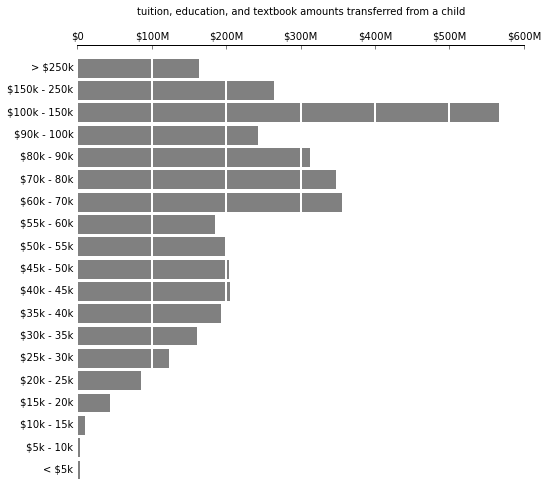

In [23]:
f, ax = plot_item(df, item_name='tuition, education, and textbook amounts transferred from a child')

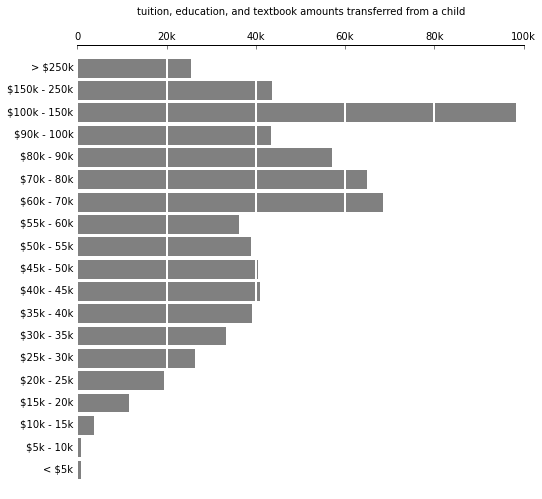

In [20]:
f, ax = plot_item(df, item_name='tuition, education, and textbook amounts transferred from a child', item_unit='#')

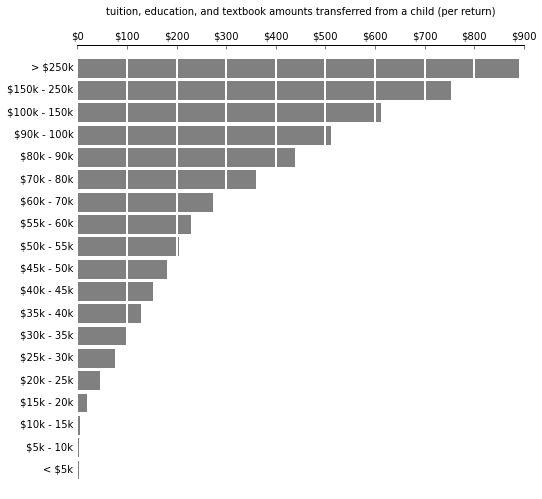

In [30]:
f, ax = plot_item(df, item_name='tuition, education, and textbook amounts transferred from a child', item_unit='$',divisor="per_return")

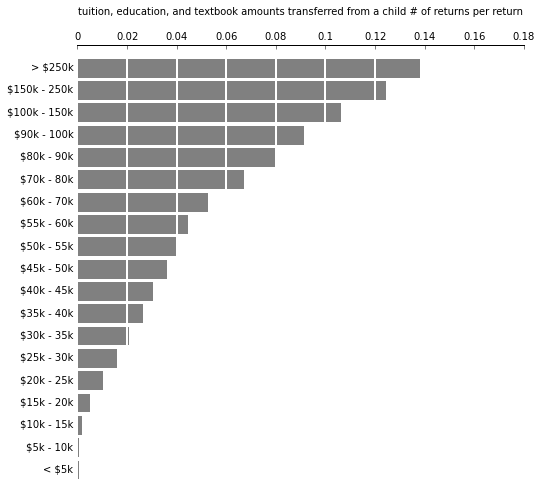

In [28]:
f, ax = plot_item(df, item_name='tuition, education, and textbook amounts transferred from a child', item_unit='#',divisor="per_return")

There are a few distinct types of plots we can make, all by income bucket:
* total value of all claims
* average value of each claim
* average value of claim per return
* average value per return as fraction of income (this may only make sense for seeing the average tax rate?)
* total number of tax claims
* fraction of returns with claim

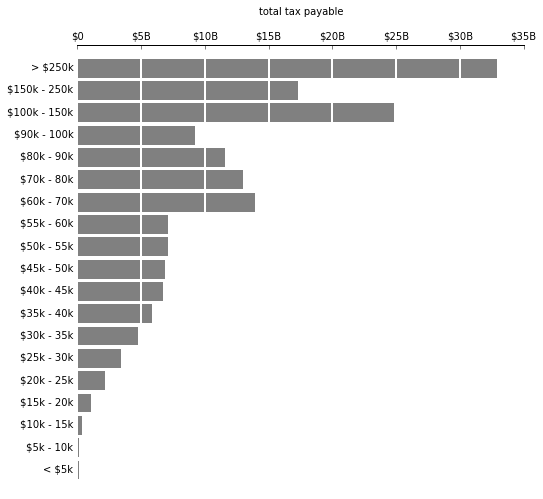

In [31]:
f, ax = plot_item(df, item_name='total tax payable')

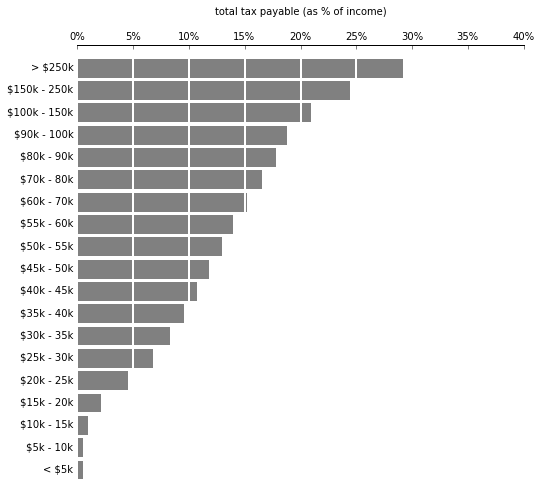

In [32]:
f, ax = plot_item(df, item_name='total tax payable', item_unit='$', divisor="per_dollar_income")

#### Task: Make a bar graph that shows the number of tax returns in each income bin

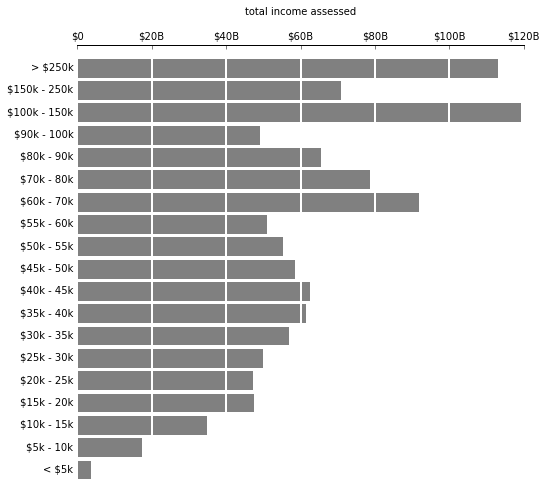

In [33]:
f, ax = plot_item(df, item_name='total income assessed', item_unit='$')

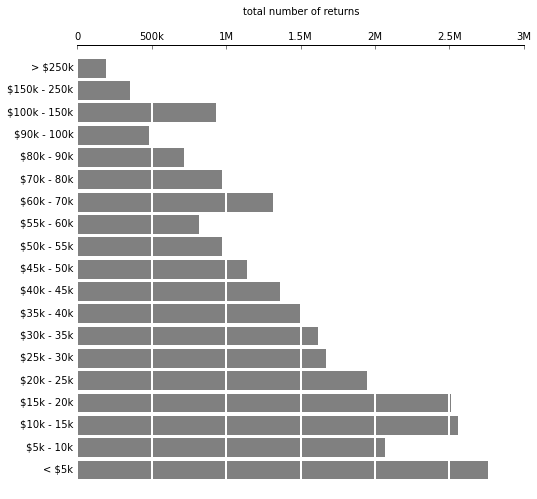

In [35]:
f, ax = plot_item(df, item_name='total number of returns', item_unit='#')

#### Task: Plot the tax income for each income bin

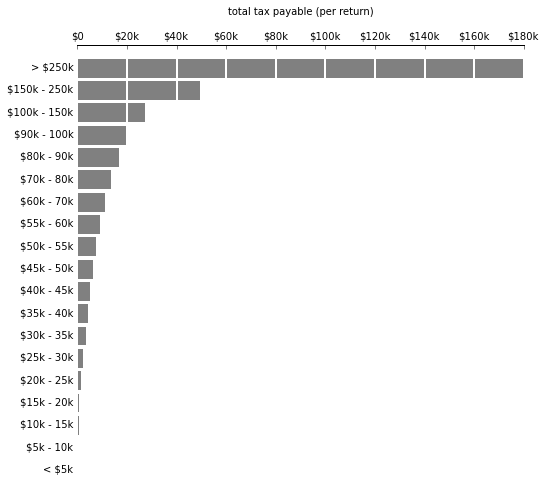

In [36]:
f, ax = plot_item(df, 'total tax payable', divisor="per_return")

#### More exploration

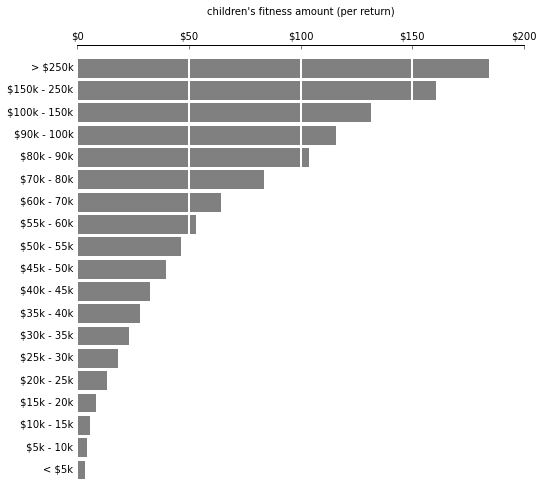

In [37]:
f, ax = plot_item(df, item_name="children's fitness amount", divisor="per_return")

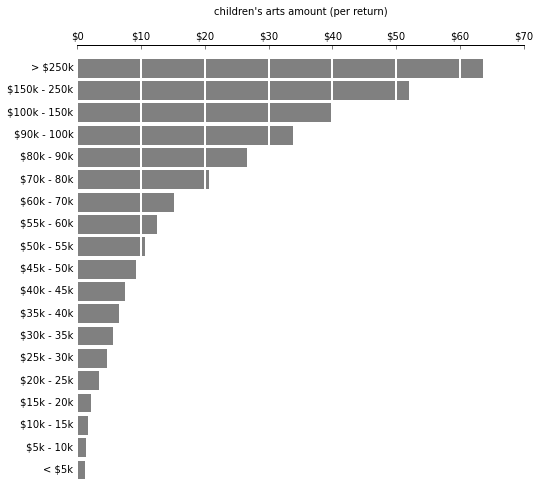

In [38]:
f, ax = plot_item(df, item_name="children's arts amount", divisor="per_return", tax_year=2011)

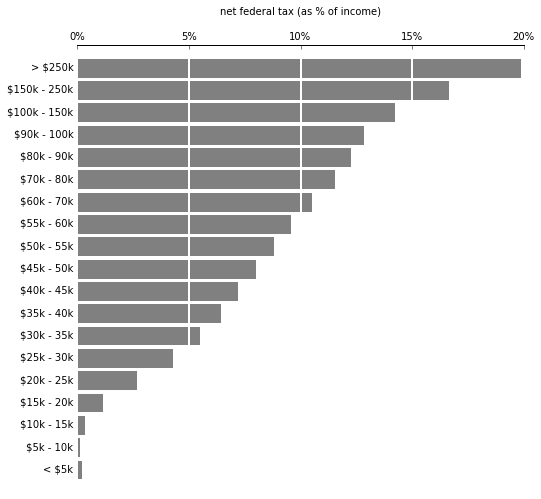

In [39]:
f, ax = plot_item(df, item_name="net federal tax", divisor="per_dollar_income", tax_year=2011)

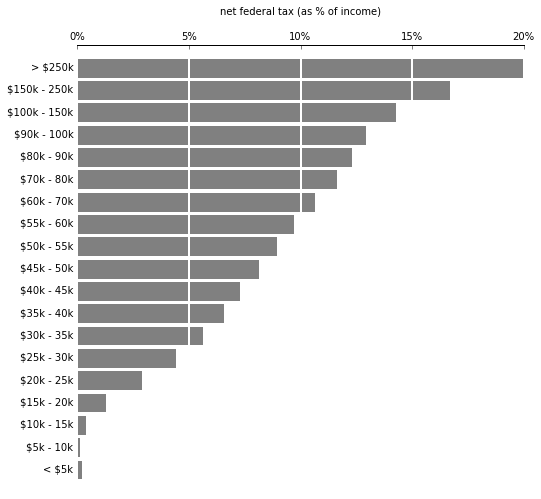

In [40]:
f, ax = plot_item(df, item_name="net federal tax", divisor="per_dollar_income", tax_year=2010)

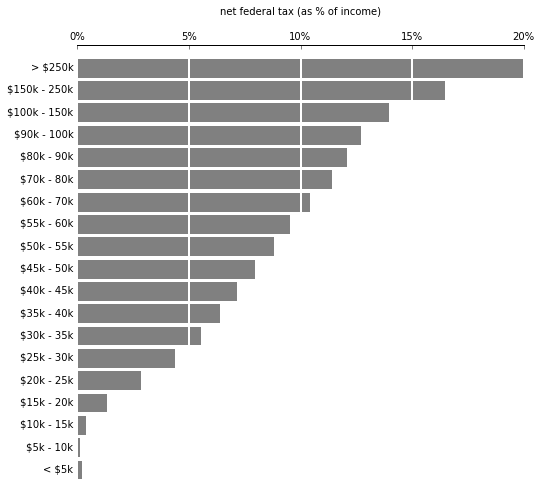

In [41]:
f, ax = plot_item(df, item_name="net federal tax", divisor="per_dollar_income", tax_year=2009)

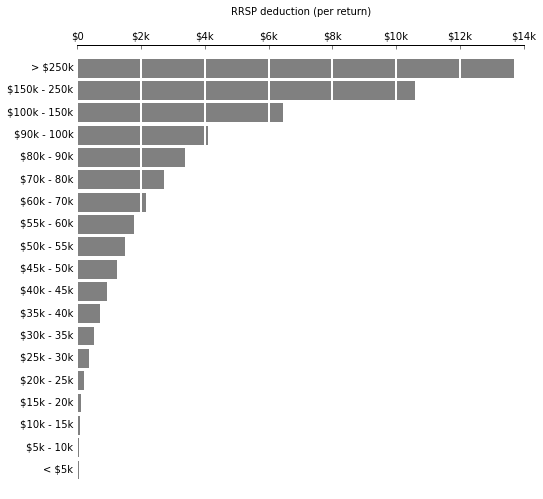

In [44]:
f, ax = plot_item(df, item_name='RRSP deduction', divisor="per_return", tax_year=2011)

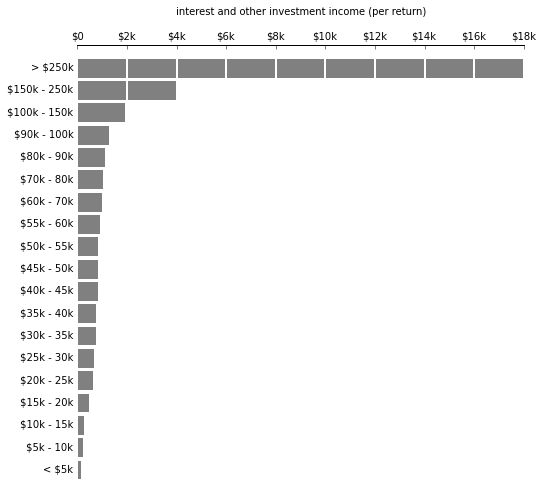

In [45]:
f, ax = plot_item(df, item_name='interest and other investment income', divisor="per_return")

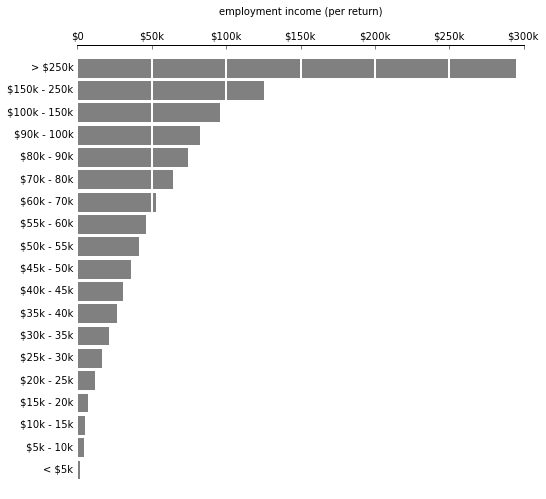

In [46]:
f, ax = plot_item(df, item_name='employment income', divisor="per_return")

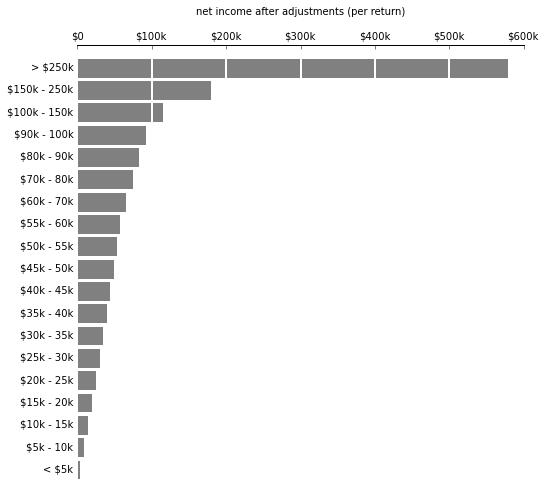

In [47]:
f, ax = plot_item(df, item_name='net income after adjustments', divisor="per_return")

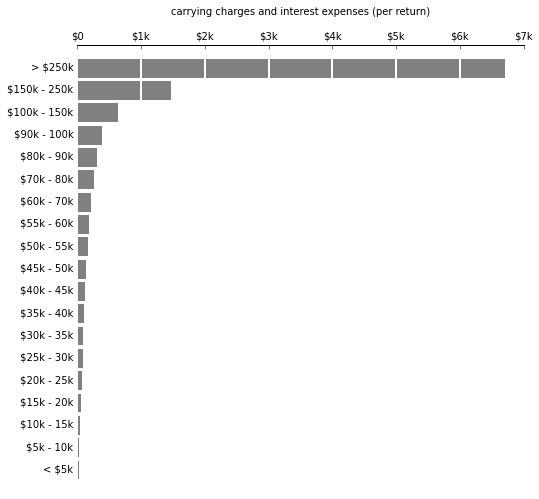

In [48]:
f, ax = plot_item(df, item_name='carrying charges and interest expenses', divisor="per_return")

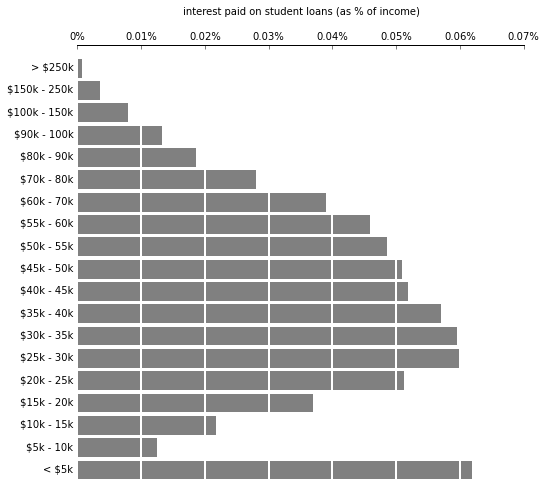

In [49]:
f, ax = plot_item(df, item_name='interest paid on student loans', divisor="per_dollar_income")